In [2]:
from Ratio import *
import numpy as np
from statsmodels.distributions.empirical_distribution import ECDF as fit_ecdf
import scipy.stats as scs
import matplotlib.pyplot as plt

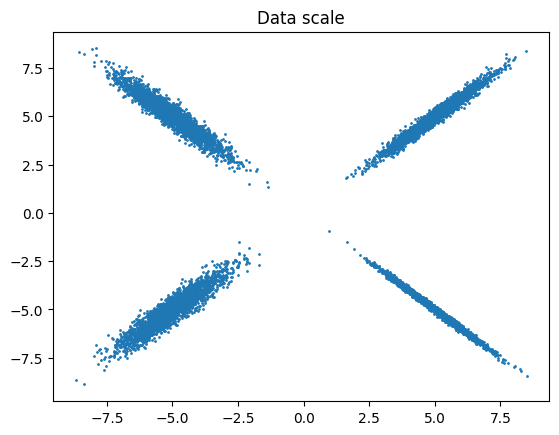

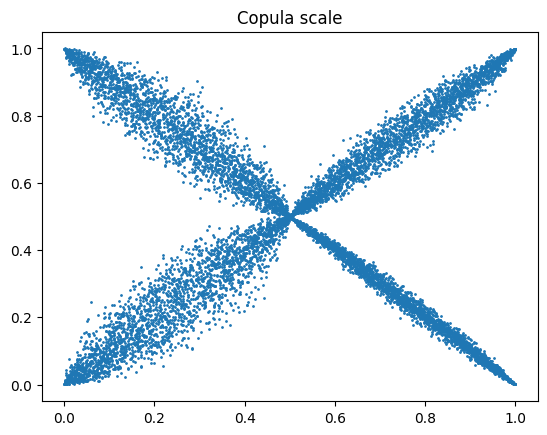

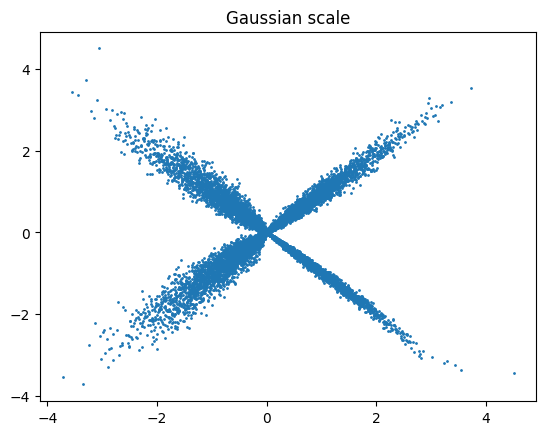

In [7]:
import numpy as np
# Gaussian copula mixture
N_TRAIN = 2500

# Define means and covariances for 5 Gaussians
mu_1 = -5 * np.ones(2)
sigma_1 = np.array([[1, 0.93], [0.93, 1]])

mu_2 = 5 * np.ones(2)
sigma_2 = np.array([[1, 0.98], [0.98, 1]])

mu_3 = np.array([-5,5])
sigma_3 = np.array([[1, -0.95], [-0.95, 1]])

mu_4 = np.array([5,-5])
sigma_4 = np.array([[1, -0.996], [-0.996, 1]])

size_ = int((N_TRAIN))
x1 = np.random.multivariate_normal(mean=mu_1, cov=sigma_1, size=size_)
x2 = np.random.multivariate_normal(mean=mu_2, cov=sigma_2, size=size_)
x3 = np.random.multivariate_normal(mean=mu_3, cov=sigma_3, size=size_)
x4 = np.random.multivariate_normal(mean=mu_4, cov=sigma_4, size=size_)
X = np.vstack([x1, x2, x3, x4])
np.random.shuffle(X)
plt.scatter(X[:,0],X[:,1],s=1)
plt.title('Data scale')
plt.show()
# Fit ecdf for marginal distributions
cdf_1 = fit_ecdf(X[:, 0])
cdf_2 = fit_ecdf(X[:, 1])
u_1_mix = cdf_1(X[:, 0])
u_2_mix = cdf_2(X[:, 1])
plt.scatter(u_1_mix,u_2_mix,s=1)
plt.title('Copula scale')
plt.show()

# transform to Gaussian space
data_gaussian = np.stack([scs.norm.ppf(u_1_mix), scs.norm.ppf(u_2_mix)], axis=1)
data_gaussian = np.clip(data_gaussian, -4.5, 4.5)
plt.scatter(data_gaussian[:,0],data_gaussian[:,1],s=1)
plt.title('Gaussian scale')
plt.show()

In [4]:
ratio_copula = Ratio(h_dim=100, in_dim=2, h_layers=5, normalising_cst = True, c = 1.0)

In [ ]:
# Takes 40s on CPU

optimizer = torch.optim.Adam(ratio_copula.parameters(), lr=0.002)
for epoch in range(500):
    optimizer.zero_grad()
    r_p = ratio_copula(torch.tensor(data_gaussian).float())
    r_q = ratio_copula(torch.tensor(scs.norm.rvs(size=(data_gaussian.shape[0],data_gaussian.shape[1]))).float())
    loss = loss_nce(r_p, r_q, data_gaussian.shape[0], data_gaussian.shape[0])
    loss.backward()
    optimizer.step()
    if epoch % 1 == 0 and epoch > 0:
        with torch.no_grad():
             print(f'Epoch {epoch}, loss and normalising constant {loss.item()}', ratio_copula.c.item())

Epoch 1, loss and normalising constant 1.551455020904541 0.9992965459823608
Epoch 2, loss and normalising constant 1.4256645441055298 0.9995017647743225
Epoch 3, loss and normalising constant 1.4599380493164062 0.99896240234375
Epoch 4, loss and normalising constant 1.355358362197876 0.9983121156692505
Epoch 5, loss and normalising constant 1.3485759496688843 0.9979883432388306
Epoch 6, loss and normalising constant 1.3628053665161133 0.9980661869049072
Epoch 7, loss and normalising constant 1.3342992067337036 0.9983745813369751
Epoch 8, loss and normalising constant 1.3124377727508545 0.9986892342567444
Epoch 9, loss and normalising constant 1.3193440437316895 0.9988347887992859
Epoch 10, loss and normalising constant 1.3215444087982178 0.9987773895263672
Epoch 11, loss and normalising constant 1.2953977584838867 0.9986094832420349
Epoch 12, loss and normalising constant 1.2717885971069336 0.9984766244888306
Epoch 13, loss and normalising constant 1.2760827541351318 0.9984859228134155

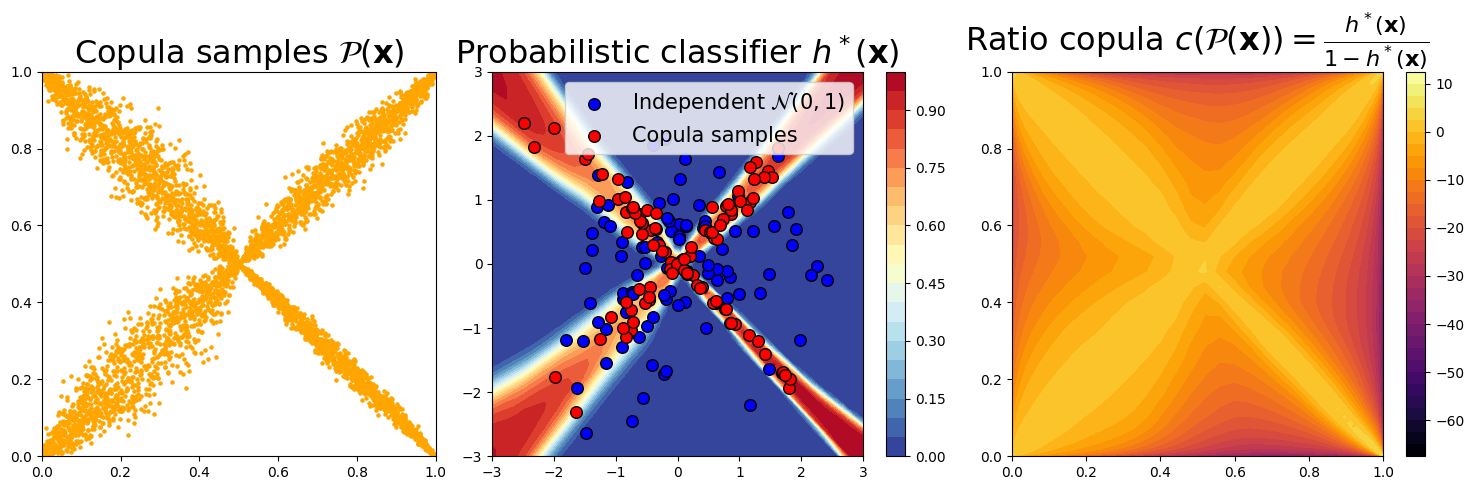

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import scipy.stats

# Set font size
font_size = 23

# Assuming ratio_copula is already trained
# Create a grid for plotting
x, y = np.meshgrid(np.linspace(-5, 5, 100), np.linspace(-5, 5, 100))
z = torch.tensor(np.column_stack((x.flatten(), y.flatten())))
gauss = scipy.stats.norm.pdf(x) * scipy.stats.norm.pdf(y)

# Get the ratio
r = ratio_copula(z.float()).detach().numpy()
Z = np.log(r.reshape(100, 100))

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5), gridspec_kw={'width_ratios': [0.85, 1, 1]})

# First subplot: scatter plot of u_1_mix and u_2_mix
axes[0].scatter(u_1_mix[:5000], u_2_mix[:5000], s=5, c='orange')
axes[0].set_xlim(0, 1)
axes[0].set_ylim(0, 1)
axes[0].set_title(r'Copula samples $\mathcal{P}(\mathbf{x})$', fontsize=font_size)

# Second subplot: contour plot of r/(1+r) with scatter plots of data_gaussian[:100] and torch.randn(100,2)
r_transformed = r / (1 + r)
Z_transformed = r_transformed.reshape(100, 100)
contour = axes[1].contourf(x, y, Z_transformed, levels=20, cmap='RdYlBu_r')

axes[1].scatter(torch.randn(100, 2)[:, 0], torch.randn(100, 2)[:, 1], color='blue', edgecolors="k", s=70, label=r'Independent $\mathcal{N}(0,1)$', marker='o')
axes[1].scatter(data_gaussian[:100, 0], data_gaussian[:100, 1], color='red', s=70, label='Copula samples', edgecolors="k", marker='o')
axes[1].set_xlim(-3, 3)
axes[1].set_ylim(-3, 3)
axes[1].set_title(r'Probabilistic classifier $h^*(\mathbf{x})$', fontsize=font_size)
axes[1].legend(fontsize=15)
fig.colorbar(contour, ax=axes[1])

# Third subplot: ratio model
contour = axes[2].contourf(scipy.stats.norm.cdf(x), scipy.stats.norm.cdf(y), Z, levels=30, cmap='inferno')
axes[2].set_xlim(0, 1)
axes[2].set_ylim(0, 1)
axes[2].set_title(r'Ratio copula $c\left(\mathcal{P}(\mathbf{x})\right)=\frac{h^*(\mathbf{x})}{1-h^*(\mathbf{x})}$', fontsize=font_size)
fig.colorbar(contour, ax=axes[2])

plt.tight_layout()
plt.savefig('ratio_copula_fig1.pdf', dpi=150)